In [1]:
import pandas as pd
import numpy as np
from sksurv.nonparametric import kaplan_meier_estimator as kmf
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
import matplotlib.patches as mpatches

In [2]:
selected_cell = 'Hepatic_Stellate_Cells'

In [3]:
estimation = pd.read_csv('GSE14520.Non-immune.csv',index_col=0)
estimation.head()

,Central_venous_LSECs,Cholangiocytes,Other,Hepatocyte,Portal_endothelial_Cells,Periportal_LSECs,Hepatic_Stellate_Cells,Erythroid_Cells,P-value,Correlation,RMSE
Mixture,,,,,,,,,,,
GSM362947,0.000000,0.000000,0.000000,0.786213,0.000000,0.156330,0.057457,0.000000,0,0.799634,0.837335
GSM362948,0.000000,0.013586,0.008070,0.738363,0.000000,0.120641,0.119340,0.000000,0,0.772421,0.849952
GSM362949,0.000789,0.165160,0.002597,0.630557,0.000000,0.102107,0.098789,0.000000,0,0.813672,0.840666
GSM362950,0.000000,0.070003,0.000000,0.699390,0.009998,0.119839,0.100770,0.000000,0,0.827382,0.836795
GSM362951,0.015375,0.000000,0.000000,0.864187,0.000000,0.082593,0.037143,0.000701,0,0.813160,0.820451


In [4]:
survival_data = pd.read_csv('GSE14520.Survival.csv',index_col=0)
survival_data.head()

,OS_E,OS,DFS_E,DFS
GSM,,,,
GSM363205,0,58.0,0,58.0
GSM363115,0,66.6,0,66.6
GSM362970,0,67.3,0,67.3
GSM363354,1,10.4,1,10.4
GSM363039,0,52.8,0,52.8


In [5]:
dfs_data = survival_data.filter(['DFS_E', 'DFS'])
dfs_data = dfs_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
dfs_data['DFS_E'] = [binary[event] for event in dfs_data['DFS_E']]
dfs_data['DFS_T'] = [time for time in dfs_data['DFS']]
dfs_data.head()

,DFS_E,DFS,DFS_T
GSM,,,
GSM363205,False,58.0,58.0
GSM363115,False,66.6,66.6
GSM362970,False,67.3,67.3
GSM363354,True,10.4,10.4
GSM363039,False,52.8,52.8


In [6]:
survival_test = estimation.merge(dfs_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,Central_venous_LSECs,Cholangiocytes,Other,Hepatocyte,Portal_endothelial_Cells,Periportal_LSECs,Hepatic_Stellate_Cells,Erythroid_Cells,P-value,Correlation,RMSE,DFS_E,DFS,DFS_T
GSM362947,0.000000,0.000000,0.000000,0.786213,0.000000,0.156330,0.057457,0.0,0,0.799634,0.837335,True,50.0,50.0
GSM362948,0.000000,0.013586,0.008070,0.738363,0.000000,0.120641,0.119340,0.0,0,0.772421,0.849952,True,8.8,8.8
GSM362949,0.000789,0.165160,0.002597,0.630557,0.000000,0.102107,0.098789,0.0,0,0.813672,0.840666,True,18.2,18.2
GSM362950,0.000000,0.070003,0.000000,0.699390,0.009998,0.119839,0.100770,0.0,0,0.827382,0.836795,True,30.1,30.1
GSM362952,0.004970,0.000000,0.000000,0.866759,0.000000,0.087406,0.040865,0.0,0,0.853724,0.808221,False,54.3,54.3


In [7]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder.head()

,Central_venous_LSECs,Cholangiocytes,Other,Hepatocyte,Portal_endothelial_Cells,Periportal_LSECs,Hepatic_Stellate_Cells,Erythroid_Cells,P-value,Correlation,RMSE,DFS_E,DFS,DFS_T
GSM363055,0.0,0.225693,0.014657,0.210286,0.000000,0.174532,0.374832,0.000000,0,0.769294,0.897411,False,7.3,7.3
GSM363271,0.0,0.051908,0.234261,0.236480,0.035312,0.079659,0.362380,0.000000,0,0.676252,0.924252,False,28.7,28.7
GSM363054,0.0,0.000000,0.038333,0.119162,0.000000,0.480970,0.342737,0.018799,0,0.078766,0.997570,False,53.8,53.8
GSM363393,0.0,0.000000,0.000000,0.293310,0.000000,0.365282,0.340880,0.000528,0,0.325026,0.966366,True,4.0,4.0
GSM363428,0.0,0.169931,0.000000,0.247857,0.033825,0.213414,0.334973,0.000000,0,0.421981,0.950666,True,3.8,3.8


In [8]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['DFS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['DFS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [9]:
optimization = optimization.dropna()
optimization = optimization.sort_values('Log Rank Test')
optimization = int(optimization.iloc[0].name)
#optimization = int(len(E)/2)

In [10]:
dfs_cut_level = survival_reorder[selected_cell][optimization]
dfs_cut_level

0.0683709017353533

In [11]:
E = list(survival_reorder['DFS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['DFS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.00446

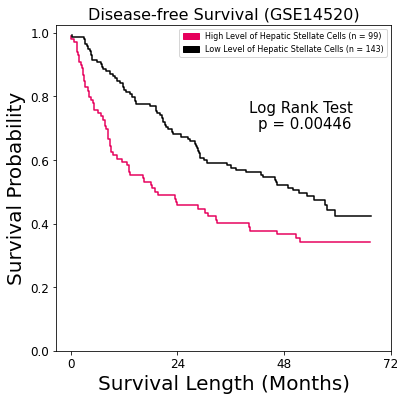

In [12]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#e6005c')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,73,24),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#e6005c',label='High Level of Hepatic Stellate Cells (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of Hepatic Stellate Cells (n = %s)'%len(E_low))
plt.text(40,0.75, 'Log Rank Test',fontsize=15)
plt.text(42,0.7, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=8)
plt.title('Disease-free Survival (GSE14520)',fontsize=16)
plt.savefig('GSE14520.%s.DFS.pdf'%selected_cell,format='pdf')

In [13]:
os_data = survival_data.filter(['OS_E', 'OS'])
os_data = os_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
os_data['OS_E'] = [binary[event] for event in os_data['OS_E']]
os_data['OS_T'] = [time for time in os_data['OS']]
os_data.head()

,OS_E,OS,OS_T
GSM,,,
GSM363205,False,58.0,58.0
GSM363115,False,66.6,66.6
GSM362970,False,67.3,67.3
GSM363354,True,10.4,10.4
GSM363039,False,52.8,52.8


In [14]:
survival_test = estimation.merge(os_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,Central_venous_LSECs,Cholangiocytes,Other,Hepatocyte,Portal_endothelial_Cells,Periportal_LSECs,Hepatic_Stellate_Cells,Erythroid_Cells,P-value,Correlation,RMSE,OS_E,OS,OS_T
GSM362947,0.000000,0.000000,0.000000,0.786213,0.000000,0.156330,0.057457,0.0,0,0.799634,0.837335,True,59.2,59.2
GSM362948,0.000000,0.013586,0.008070,0.738363,0.000000,0.120641,0.119340,0.0,0,0.772421,0.849952,False,61.4,61.4
GSM362949,0.000789,0.165160,0.002597,0.630557,0.000000,0.102107,0.098789,0.0,0,0.813672,0.840666,True,18.2,18.2
GSM362950,0.000000,0.070003,0.000000,0.699390,0.009998,0.119839,0.100770,0.0,0,0.827382,0.836795,False,57.5,57.5
GSM362952,0.004970,0.000000,0.000000,0.866759,0.000000,0.087406,0.040865,0.0,0,0.853724,0.808221,False,54.3,54.3


In [15]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder

,Central_venous_LSECs,Cholangiocytes,Other,Hepatocyte,Portal_endothelial_Cells,Periportal_LSECs,Hepatic_Stellate_Cells,Erythroid_Cells,P-value,Correlation,RMSE,OS_E,OS,OS_T
GSM363055,0.000000,0.225693,0.014657,0.210286,0.000000,0.174532,0.374832,0.000000,0,0.769294,0.897411,False,7.3,7.3
GSM363271,0.000000,0.051908,0.234261,0.236480,0.035312,0.079659,0.362380,0.000000,0,0.676252,0.924252,False,28.7,28.7
GSM363054,0.000000,0.000000,0.038333,0.119162,0.000000,0.480970,0.342737,0.018799,0,0.078766,0.997570,False,53.8,53.8
GSM363393,0.000000,0.000000,0.000000,0.293310,0.000000,0.365282,0.340880,0.000528,0,0.325026,0.966366,True,4.0,4.0
GSM363428,0.000000,0.169931,0.000000,0.247857,0.033825,0.213414,0.334973,0.000000,0,0.421981,0.950666,True,3.8,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM363147,0.006832,0.091166,0.000000,0.847934,0.004243,0.034525,0.015205,0.000094,0,0.929072,0.776664,True,28.7,28.7
GSM363098,0.008646,0.072552,0.016461,0.864444,0.000443,0.022948,0.014496,0.000010,0,0.531002,0.893517,False,56.9,56.9
GSM363331,0.001330,0.000000,0.146513,0.773042,0.000000,0.065467,0.013649,0.000000,0,0.145590,0.991210,True,36.5,36.5
GSM363148,0.005381,0.028365,0.013993,0.913463,0.000000,0.026980,0.011186,0.000632,0,0.959525,0.761793,False,52.4,52.4


In [16]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['OS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['OS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [21]:
#optimization = optimization.dropna()
#optimization = optimization.sort_values('Log Rank Test')
#optimization = int(optimization.iloc[0].name)
optimization = int(len(E)/2)

In [22]:
os_cut_level = survival_reorder[selected_cell][optimization]
os_cut_level

0.0584042758851351

In [23]:
E = list(survival_reorder['OS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['OS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.11061

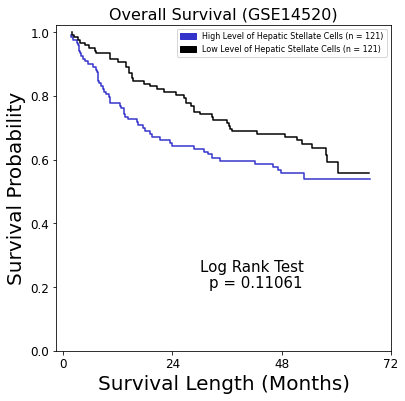

In [24]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#3333cc')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,73,24),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#3333cc',label='High Level of Hepatic Stellate Cells (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of Hepatic Stellate Cells (n = %s)'%len(E_low))
plt.text(30,0.25, 'Log Rank Test',fontsize=15)
plt.text(32,0.2, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=8)
plt.title('Overall Survival (GSE14520)',fontsize=16)
plt.savefig('GSE14520.%s.OS.pdf'%selected_cell,format='pdf')

In [25]:
estimation = estimation.sort_values(selected_cell,ascending=False)
x = []
y = []
for key,value in enumerate(estimation[selected_cell]):
    x.append(key)
    y.append(value)

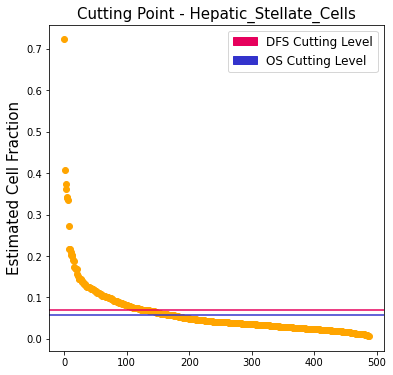

In [26]:
plt.figure(figsize=(6,6))
plt.scatter(x,y,color='orange')
plt.axhline(y=os_cut_level, xmin=0, xmax=100,color='#3333cc')
plt.axhline(y=dfs_cut_level, xmin=0, xmax=100,color='#e6005c')
plt.ylabel('Estimated Cell Fraction',fontsize=15)
plt.title('Cutting Point - %s'%selected_cell,fontsize=15)
dfs_patch = mpatches.Patch(color='#e6005c',label='DFS Cutting Level')
os_patch = mpatches.Patch(color='#3333cc',label='OS Cutting Level')
plt.legend(handles=[dfs_patch,os_patch],fontsize=12)
plt.savefig('Cutting_Point.%s'%selected_cell,format='pdf')